# ANALYSE AND CLASSIFY MUSIC BY LYRICS 
### NLP Final Project
#### Group3: Danlei Qian, Siqi Jiang, Xi Zhang

In [16]:
import pandas as pd
import os
import bisect
import codecs
import nltk
from aux_bisect import *
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.util import bigrams 
from nltk.tokenize import TreebankWordTokenizer

import warnings
warnings.filterwarnings("ignore")

In [6]:
direct_LEX = 'datasets/lexicons/'

## Import the Corpus Data

In [7]:
training_df = pd.read_csv('train_lyrics_1000.csv')

LS_LYRICS = training_df['lyrics'].values 
mood = training_df['mood'].values

training_df.head()

,file,artist,title,lyrics,genre,mood,year
0,TRAAAAW128F429D538.h5,Casual,I Didn't Mean To,Verse One:\n\nAlright I might\nHave had a litt...,Hip Hop/Rap,sad,1994
1,TRAAAEF128F4273421.h5,Adam Ant,Something Girls,Adam Ant/Marco Pirroni\nEvery girl is a someth...,Rock,happy,1982
2,TRAAAFD128F92F423A.h5,Gob,Face the Ashes,"I've just erased it's been a while, I've got a...",Rock,sad,2007
3,TRAABJV128F1460C49.h5,Lionel Richie,Tonight Will Be Alright,Little darling \nWhere you've been so long \nI...,R&B,happy,1986
4,TRAABLR128F423B7E3.h5,Blue Rodeo,Floating,"Lead Vocal by Greg\n\nWell, these late night c...",Rock,sad,1987


### The First Observation

In [8]:
print(LS_LYRICS[1])

Adam Ant/Marco Pirroni
Every girl is a something girl
Every girl is a something girl
Every girl is a something girl
She's got something
Every girl is a something girl
Every girl has a somehing smile
Every girl is a something girl
For a while
If I had three wishes I know mine
I would not ask the stars to shine
I wouldn't ask for gems or pearls
I'd ask for the something girls
Every girl is a something girl
From the whites of her eyes
To the tip of a curl
Every girl sends a something boy
With that something
When this old world won't treat you right
You're not feeling yourself tonight
Think of someone you can do
Relax and let that something through
Every girl is a something girl
She's got she's got something


## Filter

In [12]:
# import the stopwords
STP = nltk.corpus.stopwords.words('english')
anew0 = pd.read_csv(direct_LEX+'anew.csv')
anew1 = anew0[['Description', 'Valence Mean', 'Arousal Mean']].sort_values(by='Description')
anew2 = anew1['Description'].tolist()
print("Length me: ", len(anew2))

Length me:  1030


In [20]:
with open(direct_LEX+'positive_words_en.txt') as f:
    positive_ = f.read().splitlines()

with open(direct_LEX+'negative_words_en.txt') as f:
    negative_ = f.read().splitlines()
    
positive__neg = sorted(positive_ + negative_)
print("Length: ", len(positive__neg))

MIXCORP = anew2+positive__neg

# Stemmer
PORTERSTEM = PorterStemmer()
MIXCORP = []
for token in MIXCORP:
    MIXCORP.append(PORTERSTEM.stem(token))
MIXCORP = sorted(MIXCORP)
    

Length:  4376


In [30]:
## Process a word
def PROCESSWORD(word, sentiment, lexicon=anew2):
    word = word.lower()
    if not word in STP and word.isalpha():
        if sentiment:
            if find_index(lexicon, word):
                return word
        else:
            return word
    
    return False


def LYRICSTOKENIZER(lyric, sentiment=True):
    ## Pre-procesamos el corpus
    toktok = ToktokTokenizer()

    # Create PTSTEMMER of class PorterStemmer
    PTSTEMMER = PorterStemmer()

    words = toktok.tokenize(lyric)
    WORDSFILTERED = []
    for w in words:
        stemmed = PTSTEMMER.stem(w)
        clean_word = PROCESSWORD(stemmed, sentiment, mixed_corpus)
        if clean_word:
            WORDSFILTERED.append(clean_word)
            
    return WORDSFILTERED


#  Tokenizamos y sacamos las letras con menos de 10 palabras
LYRICSFILTERED = []
for lyric in LS_LYRICS:
    tokenized = LYRICSTOKENIZER(lyric, True)
    if len(tokenized) >= 3:
        LYRICSFILTERED.append(tokenized)
len(LYRICSFILTERED)
#print(LYRICSFILTERED[0:3])

995

## BAG OF WORD

In [50]:
from gensim import corpora

DICT = corpora.Dictionary(LYRICSFILTERED)
C_BOW = [DICT.doc2bow(lyric) for lyric in LYRICSFILTERED]
print(str(len(C_BOW)))

995


In [10]:
#print(C_BOW)

## Constructing a document-term matrix + LDA

In [37]:
from gensim.models.ldamulticore import LdaMulticore

def LDA_MODEL(corpus, num_topics, passes):
    lda_model = LdaMulticore(
        corpus, 
        num_topics=num_topics, 
        id2word = DICT, 
        passes = passes,
        workers = 3,
        minimum_probability=0.001
    )        
    return lda_model


In [38]:
def LDA_PRINTER(lda_model, num_words=8):
    prin = lda_model.print_topics(num_topics=num_topics, num_words=num_words)
    for i in prin:
        print(i)

In [46]:
## Process a word
def PROCESSWORD2(word, sentiment, lexicon=anew2):
    word = word.lower()
    if word.isalpha():
        if sentiment:
            if find_index(lexicon, word):
                return word
        else:
            return word
    
    return False


def LYRICSTOKENIZER2(lyric, sentiment=True):
    toktok = ToktokTokenizer()

    PORTERSTEM = PorterStemmer()

    words = toktok.tokenize(lyric)
    WORDSFINDER = []
    for w in words:
        stemmed = PORTERSTEM.stem(w)
        clean_word = PROCESSWORD2(stemmed, sentiment, MIXCORP)
        if clean_word:
            WORDSFINDER.append(clean_word)
            
    return WORDSFINDER


tokenized_lyrics = []
for lyric in LS_LYRICS:
    tokenized = LYRICSTOKENIZER2(lyric, False)
    if len(tokenized) >= 0:
        tokenized_lyrics.append(tokenized)
len(tokenized_lyrics)


def CONTEXT_CATCHER(word, corpus):
    CONTEXT_CORPUS = []
    for lyric in corpus:
        CONTEXT_LYRICS = []
        for i in range(len(lyric)):
            if word == lyric[i]:
                CONTEXT_WORD = []
                try:
                    CONTEXT_WORD.append(lyric[i-3])
                    CONTEXT_WORD.append(lyric[i-2])
                    CONTEXT_WORD.append(lyric[i-1])
                    CONTEXT_WORD.append(lyric[i])
                    CONTEXT_WORD.append(lyric[i+1])
                    CONTEXT_WORD.append(lyric[i+2])
                    CONTEXT_WORD.append(lyric[i+3])
                    if not CONTEXT_WORD in CONTEXT_LYRICS:
                        CONTEXT_LYRICS.append(CONTEXT_WORD)
                except:
                    pass
        if CONTEXT_LYRICS:
            CONTEXT_CORPUS.append(CONTEXT_LYRICS)
    return CONTEXT_CORPUS


In [53]:
%%time
# Resumen LDA
num_topics = 6
lda_model = LDA_MODEL(C_BOW, num_topics, 200)
LDA_PRINTER(lda_model)

(0, '0.052*"time" + 0.027*"life" + 0.026*"live" + 0.018*"heart" + 0.018*"fall" + 0.017*"world" + 0.016*"free" + 0.016*"right"')
(1, '0.072*"babi" + 0.036*"well" + 0.025*"cri" + 0.024*"home" + 0.022*"lose" + 0.020*"pleas" + 0.019*"hot" + 0.018*"time"')
(2, '0.226*"love" + 0.040*"babi" + 0.040*"girl" + 0.023*"rain" + 0.022*"heart" + 0.021*"lone" + 0.020*"time" + 0.018*"like"')
(3, '0.102*"like" + 0.021*"play" + 0.019*"shit" + 0.018*"fuck" + 0.018*"song" + 0.017*"better" + 0.013*"time" + 0.010*"gun"')
(4, '0.044*"man" + 0.025*"like" + 0.024*"right" + 0.021*"mind" + 0.018*"hit" + 0.017*"boy" + 0.016*"rock" + 0.016*"girl"')
(5, '0.027*"world" + 0.023*"hand" + 0.020*"believ" + 0.020*"time" + 0.016*"lie" + 0.014*"long" + 0.014*"life" + 0.014*"dream"')
CPU times: user 2min 47s, sys: 11.2 s, total: 2min 58s
Wall time: 2min 59s


In [57]:
#pip install pyLDAvis
import pyLDAvis.gensim
    
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, C_BOW, DICT)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.027820 -0.161202       1        1  22.148561
3     -0.160720  0.032317       2        1  20.648182
2      0.204506  0.092397       3        1  17.141678
5      0.024179 -0.143315       4        1  14.026779
4     -0.165440  0.077739       5        1  13.849354
1      0.069655  0.102063       6        1  12.185447, topic_info=      Term         Freq        Total Category  logprob  loglift
79    love  1499.000000  1499.000000  Default  30.0000  30.0000
68    babi   612.000000   612.000000  Default  29.0000  29.0000
25    like  1223.000000  1223.000000  Default  28.0000  28.0000
186    man   403.000000   403.000000  Default  27.0000  27.0000
19    girl   413.000000   413.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
19    girl    48.209690   413.472656   Topic6  -4.5476  -0.0441
25    like    63.541878  1223.138916   Topic6  -4.2715  -0.8525
78    long    40.854271   291.918427   Topic6  -4.7132   0.1385
81    play    33.640720   241.159790   Topic6  -4.9074   0.1352
75   heart    34.907719   422.558197   Topic6  -4.8705  -0.3887

[434 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1758      6  0.907200     ace
1029      5  0.936446  achiev
1503      3  0.841632   adapt
1468      3  0.075602   admir
1468      6  0.831621   admir
...     ...       ...     ...
140       3  0.385250   wrong
140       4  0.305754   wrong
140       5  0.024460   wrong
1034      4  0.963555  yellow
926       5  0.952915   zombi

[858 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 6, 5, 2])

In [58]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in LYRICSFILTERED for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.8); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.savefig("out.png")

In [60]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from gensim.models.ldamulticore import LdaMulticore


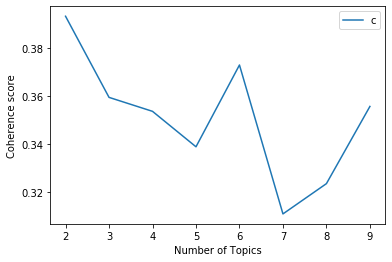

In [66]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term DICT of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term DICT and Document Term Matrix
    """
    # Creating the term DICT of our courpus, where every unique term is assigned an index. DICT = corpora.DICT(doc_clean)
    DICT = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using DICT prepared above.
    doc_term_matrix = [DICT.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return DICT,doc_term_matrix

def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    DICT,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = DICT)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

def compute_coherence_values(DICT, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : DICT : Gensim DICT
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for number_of_topics in range(start, stop, step):
        model = LDA_MODEL(doc_term_matrix, number_of_topics, 5)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=DICT, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    DICT,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(DICT, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from gensim.models.ldamulticore import LdaMulticore
start,stop,step=2,10,1
plot_graph(LYRICSFILTERED,start,stop,step)

## LSA

In [67]:
from gensim.models import LsiModel

num_topics = 6
lsi = LsiModel(C_BOW, id2word=DICT, num_topics=num_topics)
lsi.print_topics(num_topics=num_topics, num_words=8)


[(0,
  '0.835*"love" + 0.294*"like" + 0.239*"babi" + 0.185*"time" + 0.110*"girl" + 0.081*"man" + 0.078*"heart" + 0.072*"right"'),
 (1,
  '-0.672*"like" + 0.482*"love" + -0.220*"time" + -0.139*"girl" + -0.131*"right" + -0.122*"hit" + -0.120*"man" + -0.110*"shit"'),
 (2,
  '-0.488*"girl" + -0.482*"lone" + 0.416*"like" + -0.391*"babi" + -0.284*"time" + 0.159*"love" + 0.087*"hit" + -0.085*"good"'),
 (3,
  '-0.709*"time" + 0.372*"lone" + 0.327*"girl" + 0.287*"like" + -0.167*"play" + 0.113*"babi" + -0.110*"celebr" + -0.104*"song"'),
 (4,
  '0.772*"play" + 0.428*"song" + 0.231*"long" + -0.229*"babi" + 0.199*"lone" + -0.187*"time" + 0.078*"music" + 0.077*"pleas"'),
 (5,
  '0.702*"babi" + -0.336*"lone" + 0.257*"hot" + -0.256*"world" + 0.235*"play" + -0.180*"girl" + -0.169*"money" + 0.125*"fight"')]

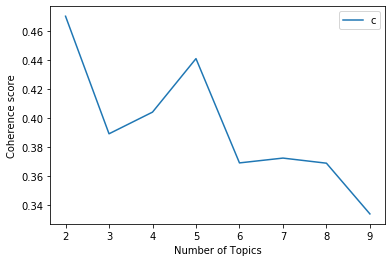

In [70]:
def prepare_corpus(doc_clean):

    DICT = corpora.Dictionary(doc_clean)
    doc_term_matrix = [DICT.doc2bow(doc) for doc in doc_clean]

    return DICT,doc_term_matrix


def compute_coherence_values(DICT, doc_term_matrix, doc_clean, stop, start=2, step=3):

    coherence_values = []
    model_list = []
    for number_of_topics in range(start, stop, step):
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = DICT)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=DICT, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    DICT,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(DICT, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    

start,stop,step=2,10,1

plot_graph(LYRICSFILTERED,start,stop,step)

## Hierarchical Dirichlet Process, HDP

In [71]:
from gensim.models import HdpModel

hdp = HdpModel(C_BOW, id2word=DICT)
hdp.print_topics(num_topics=6, num_words=8)

/Users/Fox/opt/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()


[(0,
  '0.013*like + 0.011*love + 0.008*time + 0.007*lone + 0.007*life + 0.005*man + 0.005*live + 0.005*right'),
 (1,
  '0.005*love + 0.004*like + 0.004*fall + 0.004*babi + 0.003*fight + 0.003*peculiar + 0.003*cook + 0.003*time'),
 (2,
  '0.020*love + 0.006*time + 0.006*cri + 0.006*babi + 0.005*rain + 0.005*like + 0.004*wasp + 0.004*chanc'),
 (3,
  '0.006*like + 0.004*love + 0.004*live + 0.004*time + 0.004*scare + 0.003*object + 0.003*welcom + 0.003*fuck'),
 (4,
  '0.006*like + 0.004*girl + 0.004*unwelcom + 0.003*boy + 0.003*crown + 0.003*tomb + 0.003*faster + 0.003*loyalti'),
 (5,
  '0.006*love + 0.006*like + 0.005*mind + 0.004*time + 0.004*aliv + 0.003*hard + 0.003*invis + 0.003*doctor')]

In [ ]:
def prepare_corpus(doc_clean):

    DICT = corpora.Dictionary(doc_clean)

    doc_term_matrix = [DICT.doc2bow(doc) for doc in doc_clean]

    return DICT,doc_term_matrix

def compute_coherence_values(DICT, doc_term_matrix, doc_clean, stop, start=2, step=3):

    coherence_values = []
    model_list = []
    for number_of_topics in range(start, stop, step):
        model= HdpModel(doc_term_matrix, id2word=DICT)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=DICT, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    DICT,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(DICT, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,10,1

plot_graph(LYRICSFILTERED,start,stop,step)

/Users/Fox/opt/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()
/Users/Fox/opt/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()
/Users/Fox/opt/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  start_time = time.clock()
/Users/Fox/opt/anaconda3/lib/python3.7/site-packages/gensim/models/hdpmodel.py:467: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_count

## Cluster exploration from word

In [23]:
word = 'troubl'
print(lda_model.get_term_topics(PORTERSTEM.stem(word)))

res = CONTEXT_CATCHER(word, tokenized_lyrics)
res[:3]

[(1, 0.0014426986), (4, 0.0056598904)]


[[['muh', 'fucker', 'bringin', 'troubl', 'your', 'way', 'so']],
 [['i', 'm', 'in', 'troubl', 'i', 'think', 'i']],
 [['year', 'all', 'our', 'troubl', 'will', 'be', 'out'],
  ['now', 'on', 'our', 'troubl', 'will', 'be', 'mile']]]

## Classify new lyric

In [24]:
coldplay_love = ''''
Look at the stars
Look how they shine for you
And everything you do
Yeah they were all yellow

I came along
I wrote a song for you
And all the things you do
And it was called yellow

So then I took my turn
Oh what a thing to have done
And it was all yellow

Your skin
Oh yeah your skin and bones
Turn into something beautiful
You know you know I love you so
You know I love you so

I swam across
I jumped across for you
Oh what a thing to do

'Cause you were all yellow
I drew a line
I drew a line for you
Oh what a thing to do
And it was all yellow

Your skin
Oh yeah your skin and bones
Turn into something beautiful
And you know
For you I'd bleed myself dry
For you I'd bleed myself dry

It's true
Look how they shine for you
Look how they shine for you
Look how they shine for
Look how they shine for you
Look how they shine for you
Look how they shine

Look at the stars
Look how they shine for you
And all the things that you do
'''

coldplay_sad = '''
And the hardest part
Was letting go, not taking part
Was the hardest part

And the strangest thing
Was waiting for that bell to ring
It was the strangest start

I could feel it go down
Bittersweet I could taste in my mouth
Silver lining the cloud
Oh and I
I wish that I could work it out

And the hardest part
Was letting go, not taking part
You really broke my heart, oh

And I tried to sing
But I couldn't think of anything
And that was the hardest part, oh

I could feel it go down
You left the sweetest taste in my mouth
You're silver lining the clouds
Oh and I
Oh and I
I wonder what it's all about
I wonder what it's all about

Everything I know is wrong
Everything I do, it's just comes undone
And everything is torn apart

Oh and it's the hardest part
That's the hardest part
Yeah that's the hardest part
That's the hardest part
'''

eminem_violence = '''
I told y'all mothafuckas I was comin' back 
What now nigga what now what 
You's the projects nigga
One shot two shot three shot four shots 
All I hear is gunshots this is where the fun stops 
Bodies drop hit the floor music's off 
Parties stop, everybody hit the door someone's lickin' shots off
You bitches is gone I'm dropped in the club 
And I'm tryna run and get my motherfuckin' gun 
(Nigga what about your wife) 
Nigga fuck my wife I'm tryna run and save my motherfuckin' life 
Oh shit the shoot is comin' 
Bitches, hoes niggas is runnin' 
People shot all over the floor 
And I'm tryna make it to the St. Andrew's door 
That's the sound of the glock 
Even D-J House fucked around and go shot 
I done messed around and forgot my tec 
I don't see nobody but Fab Five and Hex 
(Kuniva you aight) 
These niggas is trippin' 
(Where's Bizarre at?) 
I'm tryna slip through the exit and get to where my car is at 
Bitches screamin' everywhere and niggas is wildin' 
Two minutes ago we was all jokin' and smilin' 
This chick is clingin' onto me sobbin' and sighin' 
Sayin' she didn't mean to diss me earlier and she cryin' 
But its real and cats is gettin' killed 
So I hugged her and used her body as a human shield 
And she got hit now she yellin' 
(Don't leave me!) 
I told her I'd be right back and the dumb bitch believed me 
I squeezed through the back door and made my escape 
I ran and got my 38 I hope its not to late
One shot two shot three shot four shots 
All I hear is gunshots this is where the fun stops 
Bodies drop hit the floor music's off 
Parties stop, everybody hit the door someone's lickin' shots off
I'm on seven mile what the fuck was that 
Damn somebody hit me from the back 
(With they car?) 
With a gat nigga and my tire is flat 
And I just hit a pole, them niggas some hoes 
(Is you hit?) 
I don't know but I can tell you what they drove 
It was a black Mitsubishi 
(Shit that's the clique we beefin' wit I swear) 
Man and I was on my way there 
Believe me I'm leavin' a carcus today 
I'm a park my car and walk the rest of the way 
I'm in the mood to strut, my A-K ain't even tuck 
I'm a meet you at the club we goin' fuck these hoes up
One shot two shot three shot four shots 
All I hear is gunshots this is where the fun stops 
Bodies drop hit the floor music's off 
Parties stop, everybody hit the door someone's lickin' shots off
I never seen no shit like this is my life before 
People will still camp out from the night before 
Sleepin' outside the door waitin' in line 
Still tryna get inside the club to see D12 perform 
The fire marshals no, the venue's too small 
People are wall to wall three thousand and some odd vans 
And some come walk from out the parkin' lot 
Get into an argument over a parkin' spot 
He's about to pull his gun out and let's a few of 'em off 
Missed who he's aimin' for six feet away's the door 
In St. Andrew's hall not a stray slidin' all over the place 
Sprays one bitch in the face another one of 'em came through the wall 
Before anyone could even hear the first shot go off 
I'm posted up by the bar havin' a Mozeltoff 
Bullet wizzed right by my ear damn near shot it off 
Thank god I'm alive I gotta find Denaun 
And where the fuck is Von he usually tucks one on him 
Wait a minute I think I just saw Bizarre 
Nah I guess not, what the fuck oh my god it was 
I never saw him run so fast in my life 
Look at him haulin' ass I think he left his wife 
There she is on the ground bein' trampled 
I go to grab her up by the damn hand and I can't pull her 
God damn there just went another damn bullet I'm hit 
My vest is barely able to handle it, its to thin 
If I get hit again I can't do it, I scoop deep 
Follow Bizarre's path and ran through it 
And made it to the front door and collapsed on the steps 
Looked up and I seen Swift shootin' it out 
But I can't see who he's shootin' it out with 
But Denaun's right behind him squeezin' his four fifth
One shot two shot three shot four shots 
All I hear is gunshots this is where the fun stops 
Bodies drop hit the floor music's off 
Parties stop, everybody hit the door someone's lickin' shots off
It's Friday night came to this bitch right 
Big ass to my left and Desert Eagle to my right 
I ain't come in this bitch to party I came in this bitch to fight 
Although I can't stay here to fight 'cause I'm poppin' niggas tonight 
That's right bitches I'm drunk with revenge 
Shot a bouncer in the neck for tryna check when I get in 
Swift told me to meet him here so its clear that this fucker
Shoot out the back of his truck goes up in this motherfucker 
So one shot for the money two's to stop the show 
Third's for the bartender there's plenty of shots to go 
(I just wanna know who's drivin' a black Mitsubishi) 
He tried to run so Proof shot him in the knee wit a three piece
One shot two shot three shot four shots 
All I hear is gunshots this is where the fun stops 
Bodies drop hit the floor music's off 
Parties stop, everybody hit the door someone's lickin' shots off
'''

depressing_sad = '''
I was bruised and battered, I couldn't tell what I felt.
I was unrecognizable to myself.
Saw my reflection in a window and didn't know my own face.
Oh brother are you gonna leave me wastin' away
On the streets of Philadelphia.

I walked the avenue, 'til my legs felt like stone, 
I heard the voices of friends, vanished and gone, 
At night I could hear the blood in my veins, 
It was just as black and whispering as the rain, 
On the streets of Philadelphia.

Ain't no angel gonna greet me.
It's just you and I my friend.
And my clothes don't fit me no more, 
I walked a thousand miles
Just to slip this skin.

Night has fallen, I'm lyin' awake, 
I can feel myself fading away, 
So receive me brother with your faithless kiss, 
Or will we leave each other alone like this
On the streets of Philadelphia.
'''

love_happy = '''
Imagine me and you, I do
I think about you day and night, it's only right
To think about the girl you love and hold her tight
So happy together
If I should call you up, invest a dime
And you say you belong to me and ease my mind
Imagine how the world could be, so very fine
So happy together
I can't see me lovin' nobody but you
For all my life
When you're with me, baby the skies'll be blue
For all my life
Me and you and you and me
No matter how they toss the dice, it had to be
The only one for me is you, and you for me
So happy together
I can't see me lovin' nobody but you
For all my life
When you're with me, baby the skies'll be blue
For all my life
Me and you and you and me
No matter how they toss the dice, it had to be
The only one for me is you, and you for me
So happy together
Ba-ba-ba-ba ba-ba-ba-ba ba-ba-ba ba-ba-ba-ba
Ba-ba-ba-ba ba-ba-ba-ba ba-ba-ba ba-ba-ba-ba
Me and you and you and me
No matter how they toss the dice, it had to be
The only one for me is you, and you for me
So happy together
So happy together
How is the weather
So happy together
We're happy together
So happy together
Happy together
So happy together
So happy together (ba-ba-ba-ba ba-ba-ba-ba)

'''


In [25]:
###LDA
# Love
new_tokenized = LYRICSTOKENIZER(coldplay_love)
vec = DICT.doc2bow(new_tokenized)
topics_list = lda_model[vec]
print("Yellow - Love")
print("Sentiment Words")
print(set(new_tokenized))
print(topics_list)
print

# Love Melancholic, sad
new_tokenized = LYRICSTOKENIZER(coldplay_sad)
vec = DICT.doc2bow(new_tokenized)
topics_list = lda_model[vec]
print("Hardest part - Love Sad")
print("Sentiment Words")
print(set(new_tokenized))
print(topics_list)
print

# Depressing, sad
new_tokenized = LYRICSTOKENIZER(depressing_sad)
vec = DICT.doc2bow(new_tokenized)
topics_list = lda_model[vec]
print("Street of philadelphia - Depressing, sad")
print("Sentiment Words")
print(set(new_tokenized))
print(topics_list)
print

# Violence, Anger
new_tokenized = LYRICSTOKENIZER(eminem_violence)
vec = DICT.doc2bow(new_tokenized)
topics_list = lda_model[vec]
print("Eminem | One shot, two shot - Violence, Anger")
print("Sentiment Words")
print(set(new_tokenized))
print(topics_list)
print


# Happy
new_tokenized = LYRICSTOKENIZER(love_happy)
vec = DICT.doc2bow(new_tokenized)
topics_list = lda_model[vec]
print("Bob Marley | Three Little Birds - Love Happy")
print("Sentiment Words")
print(set(new_tokenized))
print(topics_list)
print

Yellow - Love
Sentiment Words
{'beauti', 'yellow', 'star', 'shine', 'song', 'bleed', 'love'}
[(0, 0.007328557), (1, 0.48044166), (2, 0.007259741), (3, 0.050737765), (4, 0.44694027), (5, 0.0072920495)]
Hardest part - Love Sad
Sentiment Words
{'heart', 'wonder', 'broke', 'cloud', 'tast', 'work', 'wrong', 'part', 'undon', 'strangest'}
[(0, 0.8388665), (1, 0.007633949), (2, 0.0076130205), (3, 0.007614292), (4, 0.13063176), (5, 0.007640557)]
Street of philadelphia - Depressing, sad
Sentiment Words
{'faithless', 'black', 'bruis', 'brother', 'rain', 'batter', 'angel', 'alon', 'greet', 'kiss', 'friend', 'window', 'street', 'cloth', 'like', 'fallen', 'avenu'}
[(0, 0.26031205), (1, 0.15743834), (2, 0.33822176), (3, 0.008036384), (4, 0.05249932), (5, 0.18349217)]
Eminem | One shot, two shot - Violence, Anger
Sentiment Words
{'odd', 'face', 'mess', 'cat', 'parti', 'floor', 'strut', 'bizarr', 'vest', 'fuck', 'bullet', 'drunk', 'swift', 'money', 'car', 'wife', 'human', 'like', 'collaps', 'life', 'di

<function print>

In [26]:
####LSA
# Love
new_tokenized = LYRICSTOKENIZER(coldplay_love)
vec = DICT.doc2bow(new_tokenized)
topics_list = lsi[vec]
print("Yellow - Love")
print("Sentiment Words")
print(set(new_tokenized))
print(topics_list)
print

# Love Melancholic, sad
new_tokenized = LYRICSTOKENIZER(coldplay_sad)
vec = DICT.doc2bow(new_tokenized)
topics_list = lsi[vec]
print("Hardest part - Love Sad")
print("Sentiment Words")
print(set(new_tokenized))
print(topics_list)
print

# Depressing, sad
new_tokenized = LYRICSTOKENIZER(depressing_sad)
vec = DICT.doc2bow(new_tokenized)
topics_list = lsi[vec]
print("Street of philadelphia - Depressing, sad")
print("Sentiment Words")
print(set(new_tokenized))
print(topics_list)
print

# Violence, Anger
new_tokenized = LYRICSTOKENIZER(eminem_violence)
vec = DICT.doc2bow(new_tokenized)
topics_list = lsi[vec]
print("Eminem | One shot, two shot - Violence, Anger")
print("Sentiment Words")
print(set(new_tokenized))
print(topics_list)
print


# Happy
new_tokenized = LYRICSTOKENIZER(love_happy)
vec = DICT.doc2bow(new_tokenized)
topics_list = lsi[vec]
print("Bob Marley | Three Little Birds - Love Happy")
print("Sentiment Words")
print(set(new_tokenized))
print(topics_list)
print

Yellow - Love
Sentiment Words
{'beauti', 'yellow', 'star', 'shine', 'song', 'bleed', 'love'}
[(0, 1.8509277873861285), (1, 0.7206413260961568), (2, -0.33184725870252324), (3, -0.1114867286580482), (4, -0.554063703709364), (5, 0.2995953462615345)]
Hardest part - Love Sad
Sentiment Words
{'heart', 'wonder', 'broke', 'cloud', 'tast', 'work', 'wrong', 'part', 'undon', 'strangest'}
[(0, 0.31950515648292155), (1, -0.3332686279895505), (2, 0.12570951288251186), (3, -0.08865772438146044), (4, -0.041508976159138886), (5, 0.11708429956037533)]
Street of philadelphia - Depressing, sad
Sentiment Words
{'faithless', 'black', 'bruis', 'brother', 'rain', 'batter', 'angel', 'alon', 'greet', 'kiss', 'friend', 'window', 'street', 'cloth', 'like', 'fallen', 'avenu'}
[(0, 0.8507987433045241), (1, -1.6671045267301041), (2, -0.8345726493950828), (3, 0.4725510971620238), (4, 0.14540096000400438), (5, 0.09086909678252315)]
Eminem | One shot, two shot - Violence, Anger
Sentiment Words
{'odd', 'face', 'mess', '

<function print>

In [27]:
####HDP
# Love
new_tokenized = LYRICSTOKENIZER(coldplay_love)
vec = DICT.doc2bow(new_tokenized)
topics_list = hdp[vec]
print("Yellow - Love")
print("Sentiment Words")
print(set(new_tokenized))
print(topics_list)
print

# Love Melancholic, sad
new_tokenized = LYRICSTOKENIZER(coldplay_sad)
vec = DICT.doc2bow(new_tokenized)
topics_list = hdp[vec]
print("Hardest part - Love Sad")
print("Sentiment Words")
print(set(new_tokenized))
print(topics_list)
print

# Depressing, sad
new_tokenized = LYRICSTOKENIZER(depressing_sad)
vec = DICT.doc2bow(new_tokenized)
topics_list = hdp[vec]
print("Street of philadelphia - Depressing, sad")
print("Sentiment Words")
print(set(new_tokenized))
print(topics_list)
print

# Violence, Anger
new_tokenized = LYRICSTOKENIZER(eminem_violence)
vec = DICT.doc2bow(new_tokenized)
topics_list = hdp[vec]
print("Eminem | One shot, two shot - Violence, Anger")
print("Sentiment Words")
print(set(new_tokenized))
print(topics_list)
print


# Happy
new_tokenized = LYRICSTOKENIZER(love_happy)
vec = DICT.doc2bow(new_tokenized)
topics_list = hdp[vec]
print("Bob Marley | Three Little Birds - Love Happy")
print("Sentiment Words")
print(set(new_tokenized))
print(topics_list)
print

Yellow - Love
Sentiment Words
{'beauti', 'yellow', 'star', 'shine', 'song', 'bleed', 'love'}
[(0, 0.1830673332490134), (7, 0.3345710926511746), (37, 0.443802934317163)]
Hardest part - Love Sad
Sentiment Words
{'heart', 'wonder', 'broke', 'cloud', 'tast', 'work', 'wrong', 'part', 'undon', 'strangest'}
[(24, 0.6495281271019085), (31, 0.30588515931011373)]
Street of philadelphia - Depressing, sad
Sentiment Words
{'faithless', 'black', 'bruis', 'brother', 'rain', 'batter', 'angel', 'alon', 'greet', 'kiss', 'friend', 'window', 'street', 'cloth', 'like', 'fallen', 'avenu'}
[(0, 0.3311324122993904), (5, 0.6255974095702992)]
Eminem | One shot, two shot - Violence, Anger
Sentiment Words
{'odd', 'face', 'mess', 'cat', 'parti', 'floor', 'strut', 'bizarr', 'vest', 'fuck', 'bullet', 'drunk', 'swift', 'money', 'car', 'wife', 'human', 'like', 'collaps', 'life', 'diss', 'right', 'cliqu', 'aliv', 'reveng', 'hit', 'god', 'peopl', 'believ', 'desert', 'dumb', 'plenti', 'black', 'fight', 'kill', 'bar', 'sh

<function print>